In [110]:
import pandas as pd
import numpy as np 
import seaborn as sns
import matplotlib.pyplot as plt

Read Data from MTA Website

In [111]:
def read_mta(file_nums):
    path ='http://web.mta.info/developers/data/nyct/turnstile/turnstile_'
    allFiles = []
    for i in file_nums:
        allFiles.append(path + i + '.txt')
    df_list = [pd.read_csv(file) for file in allFiles]
    df = pd.concat(df_list, ignore_index=True)
    df.columns = df.columns.str.strip() #Exits Column name has large trailing whitespace
    return df
#get August Data YYMMDD
#Currently mta contains data from September 19, 2020 to April 04, 2020

mta = read_mta(['200919'])

"""
-----
Use the following if looking at data from June 27, 2020 to September 19, 2020
mta = read_mta(['200919', 
                '200912',
                '200905',
                '200801',
                '200808',
                '200815',
                '200822',
                '200829',
                '200725',
                '200718',
                '200711',
                '200704',
                '200627'])
-----
Use the following if looking at data from July 6, 2019 to September 28, 2019
mta = read_mta(['190928',
                 '190921',
                 '190914',
                 '190907',
                 '190831',
                 '190824',
                 '190817',
                 '190810',
                 '190803',
                 '190727',
                 '190720',
                 '190713',
                 '190706'
                 ])

"""

"\n-----\nUse the following if looking at data from June 27, 2020 to September 19, 2020\nmta = read_mta(['200919', \n                '200912',\n                '200905',\n                '200801',\n                '200808',\n                '200815',\n                '200822',\n                '200829',\n                '200725',\n                '200718',\n                '200711',\n                '200704',\n                '200627'])\n-----\nUse the following if looking at data from July 6, 2019 to September 28, 2019\nmta = read_mta(['190928',\n                 '190921',\n                 '190914',\n                 '190907',\n                 '190831',\n                 '190824',\n                 '190817',\n                 '190810',\n                 '190803',\n                 '190727',\n                 '190720',\n                 '190713',\n                 '190706'\n                 ])\n\n"

In [112]:
mta.head(5)

,C/A,UNIT,SCP,STATION,LINENAME,DIVISION,DATE,TIME,DESC,ENTRIES,EXITS
0,A002,R051,02-00-00,59 ST,NQR456W,BMT,09/12/2020,00:00:00,REGULAR,7457064,2535856
1,A002,R051,02-00-00,59 ST,NQR456W,BMT,09/12/2020,04:00:00,REGULAR,7457067,2535861
2,A002,R051,02-00-00,59 ST,NQR456W,BMT,09/12/2020,08:00:00,REGULAR,7457078,2535876
3,A002,R051,02-00-00,59 ST,NQR456W,BMT,09/12/2020,12:00:00,REGULAR,7457119,2535920
4,A002,R051,02-00-00,59 ST,NQR456W,BMT,09/12/2020,12:00:00,RECOVR AUD,26786,4009


In [113]:
mta.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 209661 entries, 0 to 209660
Data columns (total 11 columns):
 #   Column    Non-Null Count   Dtype 
---  ------    --------------   ----- 
 0   C/A       209661 non-null  object
 1   UNIT      209661 non-null  object
 2   SCP       209661 non-null  object
 3   STATION   209661 non-null  object
 4   LINENAME  209661 non-null  object
 5   DIVISION  209661 non-null  object
 6   DATE      209661 non-null  object
 7   TIME      209661 non-null  object
 8   DESC      209661 non-null  object
 9   ENTRIES   209661 non-null  int64 
 10  EXITS     209661 non-null  int64 
dtypes: int64(2), object(9)
memory usage: 17.6+ MB


In [114]:
mta.describe()

,ENTRIES,EXITS
count,2.096610e+05,2.096610e+05
mean,4.237896e+07,3.499690e+07
std,2.166274e+08,1.982265e+08
min,0.000000e+00,0.000000e+00
25%,2.646930e+05,1.111290e+05
50%,1.730230e+06,1.012140e+06
75%,6.349613e+06,4.246031e+06
max,2.128746e+09,2.123199e+09


Early things to take note of: 
* 209661 rows of data
* Large range in turnstile Entries and Exit Tickers (suggests turnstiles may have started at different times)

## Clean Data
* convert to datetime and sort in ascending order
* get change in turnstile data
* remove negative entries and exits
* remove total traffic greater than 2400
* convert datetime to day of week int


In [115]:
#convert to datetime and sort
mta['datetime'] = pd.to_datetime(mta.DATE+' '+mta.TIME)
mta.sort_values(by=['datetime'], inplace=True)

In [116]:
#recovered audits are <1% of total data. Drop!
mta.DESC.value_counts()

REGULAR       209111
RECOVR AUD       550
Name: DESC, dtype: int64

In [117]:
#only interested in regular audits. 
mta = pd.DataFrame(mta[mta.DESC == 'REGULAR'])

In [118]:
#convert ENTRIES and EXITS to number of entries and number of exits between audits
mta['n_in'] = mta.groupby(['STATION', 'UNIT', 'C/A', 'SCP'])['ENTRIES'].diff()
mta['n_out'] = mta.groupby(['STATION', 'UNIT', 'C/A', 'SCP'])['EXITS'].diff()

In [119]:
#adding n_in and n_out to get total turnstile traffic between audits
mta['turn_traffic'] = mta.n_in + mta.n_out

In [120]:
#n_in and n_out have negative quantities
mta.describe()

,ENTRIES,EXITS,n_in,n_out,turn_traffic
count,2.091110e+05,2.091110e+05,2.041570e+05,2.041570e+05,2.041570e+05
mean,4.234850e+07,3.499265e+07,5.247209e+03,2.132242e+03,7.379452e+03
std,2.165280e+08,1.982371e+08,2.501973e+06,1.077691e+06,3.579313e+06
min,0.000000e+00,0.000000e+00,-1.200344e+07,-1.663366e+07,-2.863710e+07
25%,2.644255e+05,1.112645e+05,1.000000e+00,2.000000e+00,5.000000e+00
50%,1.723604e+06,1.011338e+06,1.700000e+01,1.800000e+01,4.700000e+01
75%,6.349051e+06,4.245339e+06,6.600000e+01,6.100000e+01,1.400000e+02
max,2.128746e+09,2.123199e+09,1.130282e+09,4.864105e+08,1.616692e+09


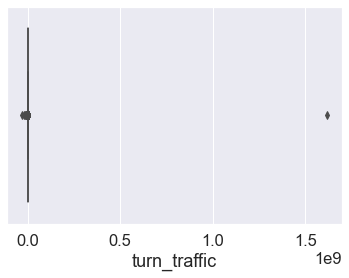

In [125]:
sns.boxplot(mta.turn_traffic)

In [126]:
len(mta[mta.turn_traffic<0])/len(mta)

0.0077853388870025965

Takeaways:
* Large gap in maximum turnstile traffic data ~1 BILLION
* Some Negative Values but they take up less than 1% of the data

Lets drop the negative values and assume that at a maximum, ten people will pass through a turnstile in a minute.  
This caps the four hour traffic at 2400 people passing through a specific turnstile. 

In [127]:
mask = (mta.n_in >= 0) & (mta.n_out >= 0) & (mta.turn_traffic >= 0) & (mta.turn_traffic < 2400)
mta = mta[mask]

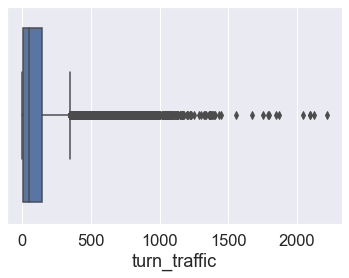

In [128]:
sns.boxplot(mta.turn_traffic)

For later use, break down the further mta data to show their individual weekdays.

In [129]:
mta['day_of_week'] = mta['datetime'].apply(lambda x : x.weekday())


## Analysis
<a href='#Ranking Stations Traffic For entire DataFrame'>Ranking Stations Traffic For Entire DataFrame</a>  
<a href='#Verifying Data From 2019'>Verifying Data From 2019</a>


<a id='Ranking Stations Traffic For entire DataFrame'></a>
### Ranking Stations Traffic For entire DataFrame

In [130]:
stations_totals = mta.groupby('STATION', as_index=False).turn_traffic.sum()

In [135]:
stations_totals.rename(columns={'turn_traffic':'total_st_traffic'}, inplace=True)

In [136]:
stations_totals.sort_values(by='total_st_traffic', ascending=False, inplace=True)

In [137]:
stations_totals[:11]

,STATION,total_st_traffic
61,34 ST-PENN STA,448535.0
59,34 ST-HERALD SQ,355745.0
110,86 ST,350144.0
9,125 ST,336779.0
14,14 ST-UNION SQ,320217.0
233,GRD CNTRL-42 ST,302224.0
46,23 ST,274861.0
68,42 ST-PORT AUTH,274861.0
217,FLUSHING-MAIN,268476.0
226,FULTON ST,260552.0


Text(0, 0.5, 'Station')

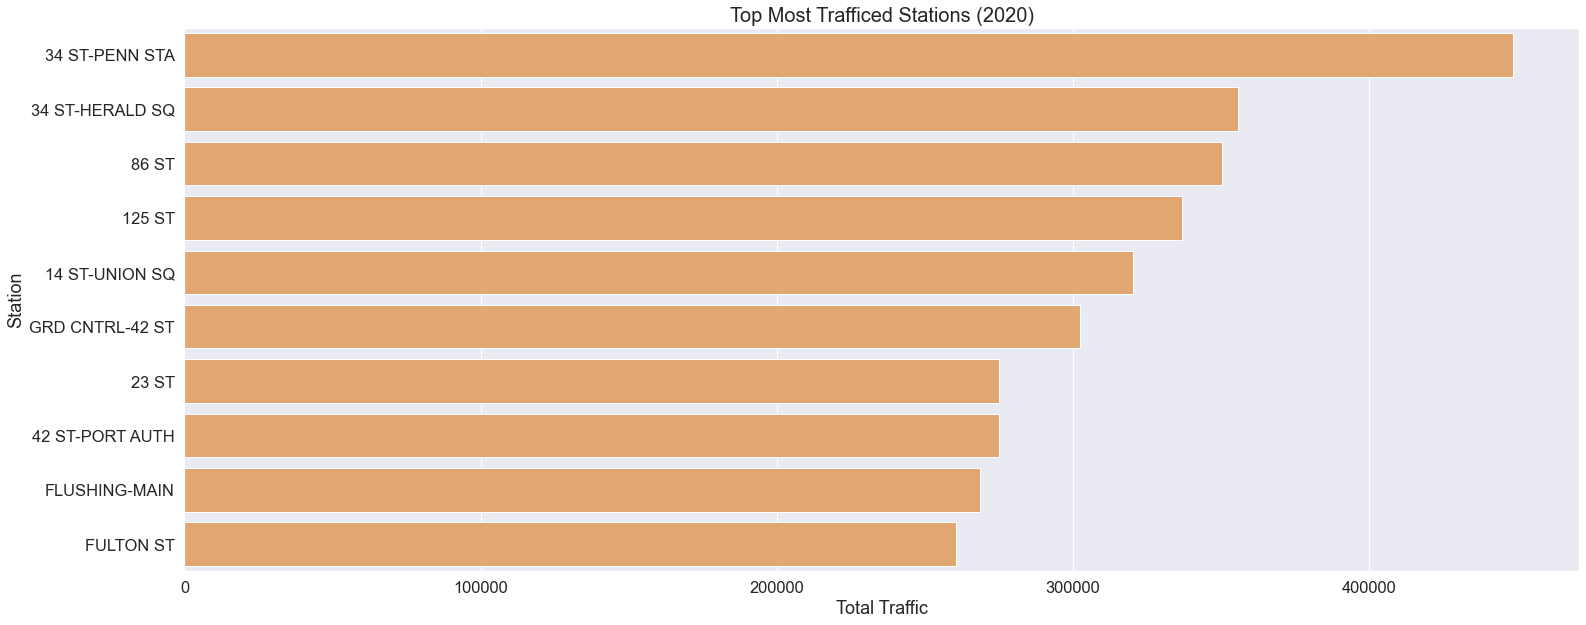

In [138]:
plt.figure(figsize=[25,10])

sns.barplot(x='total_st_traffic', y='STATION', data=stations_totals[:10], color='sandybrown')
plt.title('Top Most Trafficed Stations (2020)', fontsize=20)
plt.xlabel('Total Traffic', fontsize=18)
plt.ylabel('Station', fontsize=18);

<a id='Verifying Data From 2019'></a>
### Verifying Data From 2019

In [24]:
#loading in 2019 data
mta19 = read_mta(['190928',
                 '190921',
                 '190914',
                 '190907',
                 '190831',
                 '190824',
                 '190817',
                 '190810',
                 '190803',
                 '190727',
                 '190720',
                 '190713',
                 '190706'
                 ])

In [25]:
mta19.head(10)

,C/A,UNIT,SCP,STATION,LINENAME,DIVISION,DATE,TIME,DESC,ENTRIES,EXITS
0,A002,R051,02-00-00,59 ST,NQR456W,BMT,09/21/2019,00:00:00,REGULAR,7206966,2441290
1,A002,R051,02-00-00,59 ST,NQR456W,BMT,09/21/2019,04:00:00,REGULAR,7206983,2441292
2,A002,R051,02-00-00,59 ST,NQR456W,BMT,09/21/2019,08:00:00,REGULAR,7207003,2441323
3,A002,R051,02-00-00,59 ST,NQR456W,BMT,09/21/2019,12:00:00,REGULAR,7207073,2441395
4,A002,R051,02-00-00,59 ST,NQR456W,BMT,09/21/2019,16:00:00,REGULAR,7207260,2441450
5,A002,R051,02-00-00,59 ST,NQR456W,BMT,09/21/2019,20:00:00,REGULAR,7207572,2441489
6,A002,R051,02-00-00,59 ST,NQR456W,BMT,09/22/2019,00:00:00,REGULAR,7207748,2441513
7,A002,R051,02-00-00,59 ST,NQR456W,BMT,09/22/2019,04:00:00,REGULAR,7207773,2441521
8,A002,R051,02-00-00,59 ST,NQR456W,BMT,09/22/2019,08:00:00,REGULAR,7207784,2441536
9,A002,R051,02-00-00,59 ST,NQR456W,BMT,09/22/2019,12:00:00,REGULAR,7207848,2441602


#### Cleaning

In [26]:
mta19['datetime'] = pd.to_datetime(mta.DATE+' '+mta.TIME)

In [27]:
mta19 = pd.DataFrame(mta19[mta19.DESC == 'REGULAR'])

In [28]:
mta19.sort_values(by=['datetime'], inplace=True)

In [29]:
#convert ENTRIES and EXITS to number of entries and number of exits between audits
mta19['n_in'] = mta19.groupby(['STATION', 'UNIT', 'C/A', 'SCP'])['ENTRIES'].diff()
mta19['n_out'] = mta19.groupby(['STATION', 'UNIT', 'C/A', 'SCP'])['EXITS'].diff()

In [30]:
mta19.describe()

,ENTRIES,EXITS,n_in,n_out
count,2.675155e+06,2.675155e+06,2.670206e+06,2.670206e+06
mean,4.228635e+07,3.480474e+07,1.210188e+03,9.900765e+02
std,2.158342e+08,1.990198e+08,8.284686e+06,5.905254e+06
min,0.000000e+00,0.000000e+00,-2.129176e+09,-1.972052e+09
25%,2.863705e+05,1.203080e+05,4.000000e+00,4.000000e+00
50%,2.077570e+06,1.186331e+06,6.400000e+01,4.700000e+01
75%,6.662910e+06,4.578948e+06,2.350000e+02,1.690000e+02
max,2.129224e+09,2.123963e+09,2.129138e+09,1.971935e+09


In [31]:
#adding n_in and n_out to get total turnstile traffic between audits
mta19['turn_traffic'] = mta19.n_in + mta19.n_out

In [32]:
mask19 = (mta19.n_in >= 0) & (mta19.n_out >= 0) & (mta19.turn_traffic >= 0) & (mta19.turn_traffic < 2400)
mta19 = mta19[mask19]

In [33]:
mta19['total_st_traffic'] = mta19.groupby('STATION').turn_traffic.transform('sum')

In [34]:
mta19.sample(5)

,C/A,UNIT,SCP,STATION,LINENAME,DIVISION,DATE,TIME,DESC,ENTRIES,EXITS,datetime,n_in,n_out,turn_traffic,total_st_traffic
514493,N535,R220,00-00-02,CARROLL ST,FG,IND,09/12/2019,20:00:00,REGULAR,17053103,3379421,2020-08-31 08:00:00,818.0,136.0,954.0,1179506.0
240857,H038,R350,00-00-01,LIVONIA AV,L,BMT,09/16/2019,05:00:00,REGULAR,4280161,2579128,2020-09-07 08:00:00,9.0,3.0,12.0,393558.0
1155299,R107,R305,00-00-00,WTC-CORTLANDT,1,IRT,08/23/2019,09:00:00,REGULAR,118573,90210,2020-08-13 04:00:00,10.0,52.0,62.0,1865901.0
1381067,R194,R040,00-00-03,231 ST,1,IRT,08/15/2019,20:00:00,REGULAR,10880462,404485,2020-08-21 05:00:00,596.0,20.0,616.0,747776.0
2638245,R236,R045,00-00-02,GRD CNTRL-42 ST,4567S,IRT,07/04/2019,17:00:00,REGULAR,10517399,10500231,2020-06-22 00:00:00,55.0,276.0,331.0,16824278.0


In [35]:
mta19.STATION.value_counts()

34 ST-PENN STA     49312
FULTON ST          47361
23 ST              35838
GRD CNTRL-42 ST    32131
86 ST              30821
                   ...  
225 ST              1040
190 ST              1030
SUTTER AV           1030
CLEVELAND ST        1027
182-183 STS         1024
Name: STATION, Length: 378, dtype: int64

#### Analysis

In [36]:
stations_totals19 = mta19[['STATION', 'total_st_traffic']]

In [37]:
stations_totals19 = stations_totals19.drop_duplicates()

In [38]:
stations_totals19.sort_values(by='total_st_traffic', ascending=False, inplace=True)

In [39]:
top_ten_stations_totals19 = stations_totals19[:11]
top_ten_stations_totals19

,STATION,total_st_traffic
2615633,34 ST-PENN STA,21062609.0
2640593,GRD CNTRL-42 ST,16824278.0
2577412,34 ST-HERALD SQ,13644047.0
2577916,23 ST,13632836.0
2618653,TIMES SQ-42 ST,12819753.0
2538690,FULTON ST,12715131.0
2634700,14 ST-UNION SQ,12245719.0
2529310,42 ST-PORT AUTH,11705299.0
2526254,86 ST,11128009.0
2524784,125 ST,10363036.0


### Compare to 2020 data

In [40]:
top_ten_stations_totals20 = stations_totals[:11]
top_ten_stations_totals20

,STATION,total_st_traffic
2561076,34 ST-PENN STA,4731445.0
2603254,34 ST-HERALD SQ,3770944.0
2651082,125 ST,3723671.0
2529225,86 ST,3378209.0
2509960,14 ST-UNION SQ,3233501.0
2664502,GRD CNTRL-42 ST,3065539.0
2557646,42 ST-PORT AUTH,3017721.0
2604833,23 ST,2810212.0
2698132,FLUSHING-MAIN,2728575.0
2600693,FULTON ST,2635630.0


### adding years to dfs

In [41]:
top_ten_stations_totals19['year'] = 2019
top_ten_stations_totals20['year'] = 2020
top_ten_stations_totals19 = top_ten_stations_totals19.reset_index()
top_ten_stations_totals20 = top_ten_stations_totals20.reset_index()

<ipython-input-41-072bd00bbf76>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  top_ten_stations_totals19['year'] = 2019
<ipython-input-41-072bd00bbf76>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  top_ten_stations_totals20['year'] = 2020


In [42]:
top_ten_stations_totals19

,index,STATION,total_st_traffic,year
0,2615633,34 ST-PENN STA,21062609.0,2019
1,2640593,GRD CNTRL-42 ST,16824278.0,2019
2,2577412,34 ST-HERALD SQ,13644047.0,2019
3,2577916,23 ST,13632836.0,2019
4,2618653,TIMES SQ-42 ST,12819753.0,2019
5,2538690,FULTON ST,12715131.0,2019
6,2634700,14 ST-UNION SQ,12245719.0,2019
7,2529310,42 ST-PORT AUTH,11705299.0,2019
8,2526254,86 ST,11128009.0,2019
9,2524784,125 ST,10363036.0,2019


In [43]:
#top_ten_stations_totals19.to_excel(r'/Users/zacharybrandt/Desktop/Metis/Project_1/top_ten_stations_totals19.xlsx', index = False)

In [44]:
top_ten_stations_totals20

,index,STATION,total_st_traffic,year
0,2561076,34 ST-PENN STA,4731445.0,2020
1,2603254,34 ST-HERALD SQ,3770944.0,2020
2,2651082,125 ST,3723671.0,2020
3,2529225,86 ST,3378209.0,2020
4,2509960,14 ST-UNION SQ,3233501.0,2020
5,2664502,GRD CNTRL-42 ST,3065539.0,2020
6,2557646,42 ST-PORT AUTH,3017721.0,2020
7,2604833,23 ST,2810212.0,2020
8,2698132,FLUSHING-MAIN,2728575.0,2020
9,2600693,FULTON ST,2635630.0,2020


In [45]:
#This cell was used to export the data as excel
#top_ten_stations_totals20.to_excel(r'/Users/zacharybrandt/Desktop/Metis/Project_1/top_ten_stations_totals20.xlsx', index = False)

### Combining into one df

In [46]:
top_ten_stations_both = pd.concat([top_ten_stations_totals19, top_ten_stations_totals20], ignore_index = True)
top_ten_stations_both

,index,STATION,total_st_traffic,year
0,2615633,34 ST-PENN STA,21062609.0,2019
1,2640593,GRD CNTRL-42 ST,16824278.0,2019
2,2577412,34 ST-HERALD SQ,13644047.0,2019
3,2577916,23 ST,13632836.0,2019
4,2618653,TIMES SQ-42 ST,12819753.0,2019
5,2538690,FULTON ST,12715131.0,2019
6,2634700,14 ST-UNION SQ,12245719.0,2019
7,2529310,42 ST-PORT AUTH,11705299.0,2019
8,2526254,86 ST,11128009.0,2019
9,2524784,125 ST,10363036.0,2019


### Ploting the two

<Figure size 1440x720 with 0 Axes>

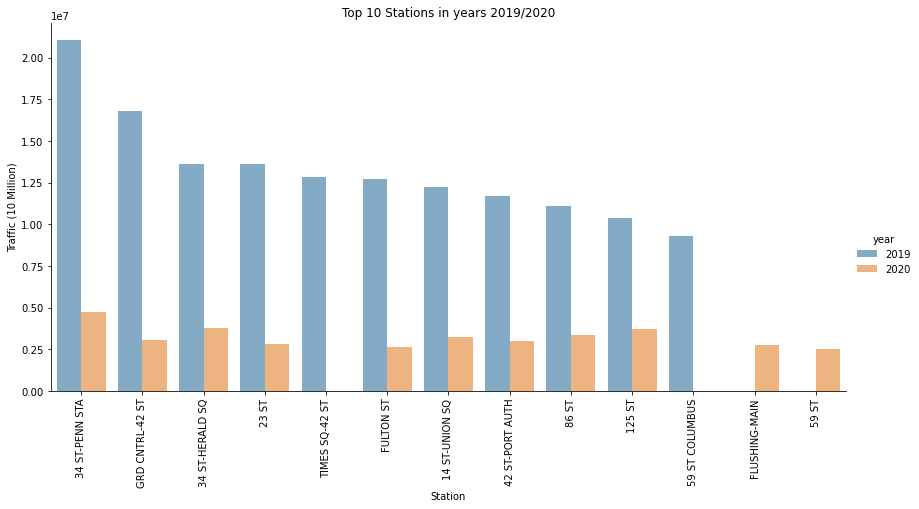

In [47]:
plt.figure(figsize=[20,10])
compare_years = sns.catplot(
    data = top_ten_stations_both, kind = "bar",
    x = "STATION", y ="total_st_traffic", hue = "year", 
    palette = sns.color_palette(), alpha=.6, height=6,
    aspect = 2
)
compare_years.set_xticklabels(rotation=90)
compare_years.set(xlabel="Station", ylabel = "Traffic (10 Million)")
compare_years.set(title = "Top 10 Stations in years 2019/2020")

In [48]:
compare_years.savefig("compare_years.png")

**Filter for Top N Stations (N=25)**

In [49]:
n=25

In [50]:
#Assume focus on top ten total traffic

#increase to top 25
s = [each for _, each in stations_totals[:n]['STATION'].items()]

In [51]:
#Change df name to top_ranking
top_ranked_df = pd.DataFrame(mta[mta.STATION.isin(s)])

In [52]:
top_ranked_df.STATION.value_counts()

34 ST-PENN STA     53056
FULTON ST          52126
GRD CNTRL-42 ST    39685
23 ST              39024
86 ST              34359
CANAL ST           31150
34 ST-HERALD SQ    28207
ATL AV-BARCLAY     27265
14 ST              26641
42 ST-PORT AUTH    25803
59 ST              25701
PATH NEW WTC       23343
TIMES SQ-42 ST     22953
125 ST             22704
14 ST-UNION SQ     22436
59 ST COLUMBUS     22321
96 ST              19957
47-50 STS ROCK     19638
CHURCH AV          19613
JKSN HT-ROOSVLT    15600
72 ST              15341
FLUSHING-MAIN      14113
JAMAICA CENTER     11662
145 ST             10872
JUNCTION BLVD       6519
Name: STATION, dtype: int64

In [53]:
top_ranked_df.head()

,C/A,UNIT,SCP,STATION,LINENAME,DIVISION,DATE,TIME,DESC,ENTRIES,EXITS,datetime,n_in,n_out,turn_traffic,day_of_week,total_st_traffic
2698132,R534,R055,01-03-00,FLUSHING-MAIN,7,IRT,06/20/2020,04:00:00,REGULAR,8811043,8522154,2020-06-20 04:00:00,1.0,2.0,3.0,5,2728575.0
2557646,N062,R011,01-05-00,42 ST-PORT AUTH,ACENQRS1237W,IND,06/20/2020,04:00:00,REGULAR,100668500,0,2020-06-20 04:00:00,0.0,0.0,0.0,5,3017721.0
2551641,N020,R101,00-00-02,145 ST,ABCD,IND,06/20/2020,04:00:00,REGULAR,11807661,12290425,2020-06-20 04:00:00,6.0,19.0,25.0,5,1781370.0
2558696,N063A,R011,00-00-03,42 ST-PORT AUTH,ACENQRS1237W,IND,06/20/2020,04:00:00,REGULAR,5014877,2274472,2020-06-20 04:00:00,4.0,7.0,11.0,5,3017721.0
2604833,N508,R453,00-00-00,23 ST,FM,IND,06/20/2020,04:00:00,REGULAR,238620663,459121876,2020-06-20 04:00:00,1.0,6.0,7.0,5,2810212.0


In [54]:
#try top_ranked_df.dt.dayofweek()
#top_ranked_df['day_of_week'] = top_ranked_df['datetime'].apply(lambda x : x.weekday())

**Determine Daily Cumulative traffic by day of week from Top n Stations of all time**

In [55]:
#or take the mean? ### Rename to cumulative?
top_ranked_df['daily_traffic'] = top_ranked_df.groupby(['STATION', 'day_of_week']).turn_traffic.transform('sum')
#Gives cumulative traffic by day of week

In [56]:
daily_df = pd.DataFrame(top_ranked_df[['STATION', 'day_of_week', 'daily_traffic']])

In [57]:
daily_df.drop_duplicates(inplace=True)

Text(0.5, 1.0, 'Daily Traffic')

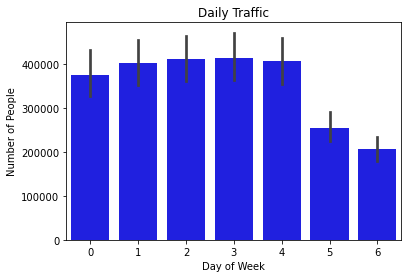

In [58]:
sns.barplot(x='day_of_week', y='daily_traffic', data=daily_df, color='b')

plt.xlabel('Day of Week')
plt.ylabel('Number of People')
plt.title('Daily Traffic')

In [59]:
top_ranked_df['traffic_by_time_by_station'] = top_ranked_df.groupby(['STATION', 'day_of_week', 'TIME']).turn_traffic.transform('sum')

In [60]:
top_ranked_df.head()

,C/A,UNIT,SCP,STATION,LINENAME,DIVISION,DATE,TIME,DESC,ENTRIES,EXITS,datetime,n_in,n_out,turn_traffic,day_of_week,total_st_traffic,daily_traffic,traffic_by_time_by_station
2698132,R534,R055,01-03-00,FLUSHING-MAIN,7,IRT,06/20/2020,04:00:00,REGULAR,8811043,8522154,2020-06-20 04:00:00,1.0,2.0,3.0,5,2728575.0,306578.0,5280.0
2557646,N062,R011,01-05-00,42 ST-PORT AUTH,ACENQRS1237W,IND,06/20/2020,04:00:00,REGULAR,100668500,0,2020-06-20 04:00:00,0.0,0.0,0.0,5,3017721.0,316092.0,2210.0
2551641,N020,R101,00-00-02,145 ST,ABCD,IND,06/20/2020,04:00:00,REGULAR,11807661,12290425,2020-06-20 04:00:00,6.0,19.0,25.0,5,1781370.0,219838.0,7293.0
2558696,N063A,R011,00-00-03,42 ST-PORT AUTH,ACENQRS1237W,IND,06/20/2020,04:00:00,REGULAR,5014877,2274472,2020-06-20 04:00:00,4.0,7.0,11.0,5,3017721.0,316092.0,2210.0
2604833,N508,R453,00-00-00,23 ST,FM,IND,06/20/2020,04:00:00,REGULAR,238620663,459121876,2020-06-20 04:00:00,1.0,6.0,7.0,5,2810212.0,269026.0,2868.0


In [61]:
top_ranked_df['d_traffic'] = top_ranked_df.groupby(['STATION', 'DATE']).turn_traffic.transform('sum')

In [62]:
top_ranked_df['mean_d_traffic'] = top_ranked_df.groupby(['STATION','day_of_week']).d_traffic.transform('mean')

### Ranking Stations filtered for Weekdays

In [63]:
wkday_df = pd.DataFrame(mta[mta.day_of_week < 5])

In [64]:
wkday_df['total_st_traffic'] = wkday_df.groupby('STATION').turn_traffic.transform('sum')

In [65]:
wkday_rank = pd.DataFrame(wkday_df[['STATION', 'total_st_traffic']])

In [66]:
wkday_rank.drop_duplicates(inplace=True)

In [67]:
wkday_rank.sort_values('total_st_traffic', ascending=False, inplace=True)

In [68]:
wkday_rank.head(25)

,STATION,total_st_traffic
2643379,34 ST-PENN STA,3870985.0
2508249,34 ST-HERALD SQ,3086514.0
2552786,125 ST,2936132.0
2529194,86 ST,2780528.0
2664849,GRD CNTRL-42 ST,2614805.0
2510551,14 ST-UNION SQ,2582463.0
2558833,42 ST-PORT AUTH,2452743.0
2561843,23 ST,2339046.0
2600788,FULTON ST,2202432.0
2698185,FLUSHING-MAIN,2185677.0


Text(0.5, 0, 'Cumulative Number of People')

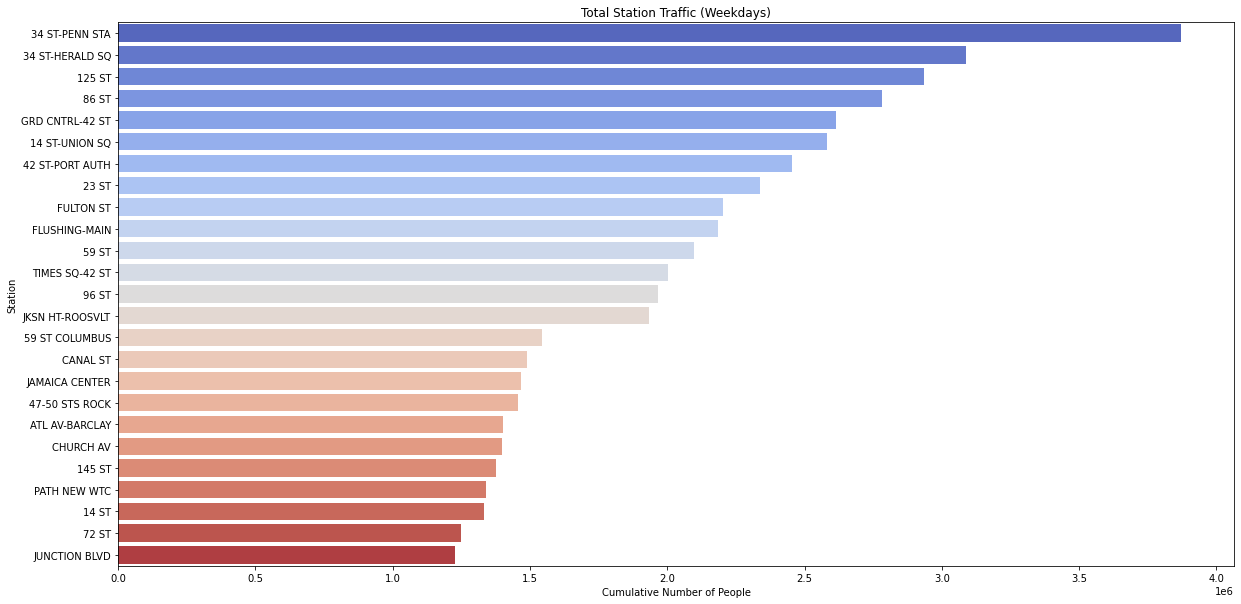

In [69]:
plt.figure(figsize=(20,10))

sns.barplot(x='total_st_traffic', y='STATION', data=wkday_rank[:25], palette='coolwarm')
plt.title('Total Station Traffic (Weekdays)')
plt.ylabel('Station')
plt.xlabel('Cumulative Number of People')

**filter for top N stations (n)**

In [70]:
n

25

In [71]:
s = [each for _, each in wkday_rank[:n]['STATION'].items()]

wkday_rank[wkday_rank.STATION.isin(s)]

,STATION,total_st_traffic
2643379,34 ST-PENN STA,3870985.0
2508249,34 ST-HERALD SQ,3086514.0
2552786,125 ST,2936132.0
2529194,86 ST,2780528.0
2664849,GRD CNTRL-42 ST,2614805.0
2510551,14 ST-UNION SQ,2582463.0
2558833,42 ST-PORT AUTH,2452743.0
2561843,23 ST,2339046.0
2600788,FULTON ST,2202432.0
2698185,FLUSHING-MAIN,2185677.0


In [72]:
wkday_df['daily_traffic'] = wkday_df.groupby(['STATION','DATE']).turn_traffic.transform('sum')

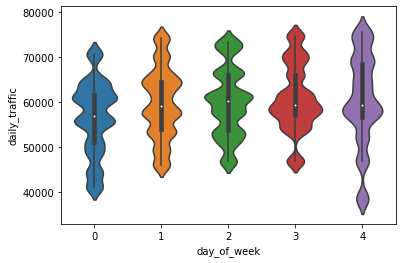

In [73]:
sns.violinplot(x='day_of_week', y='daily_traffic', data=wkday_df[wkday_df.STATION=='34 ST-PENN STA'])

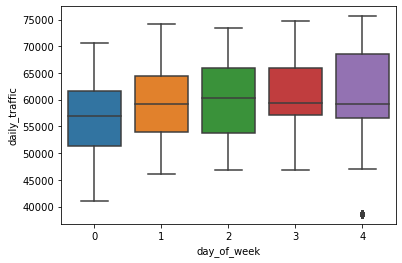

In [74]:
sns.boxplot(x='day_of_week', y='daily_traffic', data=wkday_df[wkday_df.STATION=='34 ST-PENN STA'])

### Top Stations Average Traffic by Day 

In [75]:
df = pd.DataFrame(top_ranked_df[['STATION', 'day_of_week', 'mean_d_traffic']])

In [76]:
df.drop_duplicates(inplace=True)

In [77]:
wkday_dict = {'0':'Mon',
             '1':'Tues',
             '2':'Weds',
             '3':'Thurs',
             '4':'Fri',
             '5':'Sat',
             '6':'Sun'}
df.day_of_week = df.day_of_week.map(lambda x : str(x)).map(wkday_dict)
#df = df[(df.day_of_week!='Sat') & (df.day_of_week!='Sun')]

In [78]:
s3 = s[0:2]+s[4:9]

Text(0.5, 1.0, 'Average Daily Traffic')

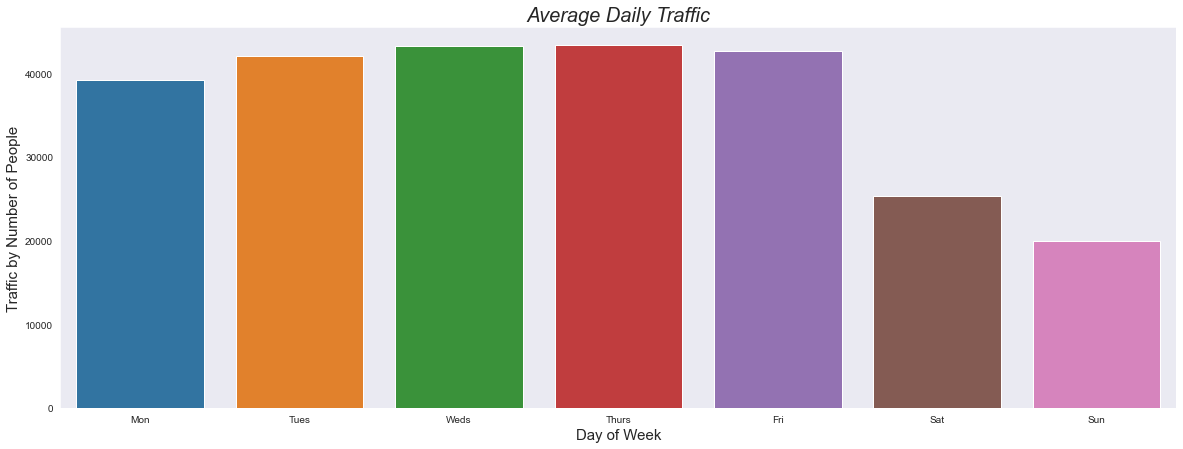

In [79]:

plt.figure(figsize=[20,7])
LIMIT = 9
sns.set_style('dark')
sns.barplot(x='day_of_week', 
            y='mean_d_traffic',  
            data=df[(df.STATION.isin(s3))], 
            order=['Mon','Tues','Weds','Thurs','Fri','Sat','Sun'],
            ci=None)
plt.xlabel('Day of Week', fontsize=15)
plt.ylabel('Traffic by Number of People', fontsize=15)
plt.title('Average Daily Traffic', fontsize=20, fontstyle='oblique')
#use s2 in hue order b/c its the top 5 in order

In [80]:
pivot_df = df.pivot(index='day_of_week', columns='STATION', values='mean_d_traffic')
pivot_df

STATION,125 ST,14 ST,14 ST-UNION SQ,145 ST,23 ST,34 ST-HERALD SQ,34 ST-PENN STA,42 ST-PORT AUTH,47-50 STS ROCK,59 ST,...,CANAL ST,CHURCH AV,FLUSHING-MAIN,FULTON ST,GRD CNTRL-42 ST,JAMAICA CENTER,JKSN HT-ROOSVLT,JUNCTION BLVD,PATH NEW WTC,TIMES SQ-42 ST
day_of_week,,,,,,,,,,,,,,,,,,,,,
Fri,47322.862248,21070.620841,41381.692732,21749.769231,36068.218970,48015.087871,60420.934168,38715.077781,20880.287852,32294.407909,...,23813.703237,21689.855670,33949.620868,34302.633115,39681.194320,22272.299754,33224.205722,19256.615385,20751.664277,30335.269091
Mon,42732.768971,18840.495332,36591.336882,19964.547315,32535.023903,44108.870904,56526.215720,35935.911288,20583.384670,30228.820859,...,21363.792956,20740.300458,31084.802432,31364.763464,37379.505298,20954.357417,28687.044268,17885.140107,19002.641252,28914.356599
Sat,33194.930276,14051.176833,28887.874527,16995.998695,20790.101966,29682.406682,36028.029424,24349.237781,7185.321739,18869.648291,...,15857.382340,15370.601014,23699.002775,18354.363624,19663.113184,13123.488016,23390.818468,16123.644252,11446.965517,19053.436896
Sun,27485.078834,11266.505683,21360.692308,14319.958683,15537.334585,23221.909294,30292.283675,19163.934122,5009.338375,14315.423491,...,12429.638199,13046.597173,18012.055937,15185.729492,15000.491441,10647.344401,18457.907810,13235.761697,8997.063549,15417.846154
Thurs,46461.786638,21361.702590,40181.625709,21689.859729,37904.749731,49252.568520,60983.310340,38510.324242,23563.952245,33988.983301,...,23483.640181,21920.288510,33790.543456,34804.484771,41901.475556,22381.303993,30295.980930,19197.983957,21414.028035,31762.649925
Tues,44513.685556,20219.113193,38838.456372,20871.230769,35637.782477,47698.899383,59782.167124,37754.085676,23254.909871,32490.243583,...,22553.153604,21237.912950,33799.349544,34016.814517,41079.563403,23108.833657,30336.395185,18534.846154,20591.794580,31002.883037
Weds,45084.554964,21104.149709,41617.783144,21534.989096,37789.688328,48669.661139,60136.802985,38239.910027,23758.461538,33399.193813,...,23309.540704,21899.426790,34165.762663,35039.014312,41263.607500,23125.721438,30055.581560,19391.846154,21249.241148,32038.230769


Text(0.5, 1.0, 'Daily Traffic of Top Ten Busiest Stations')

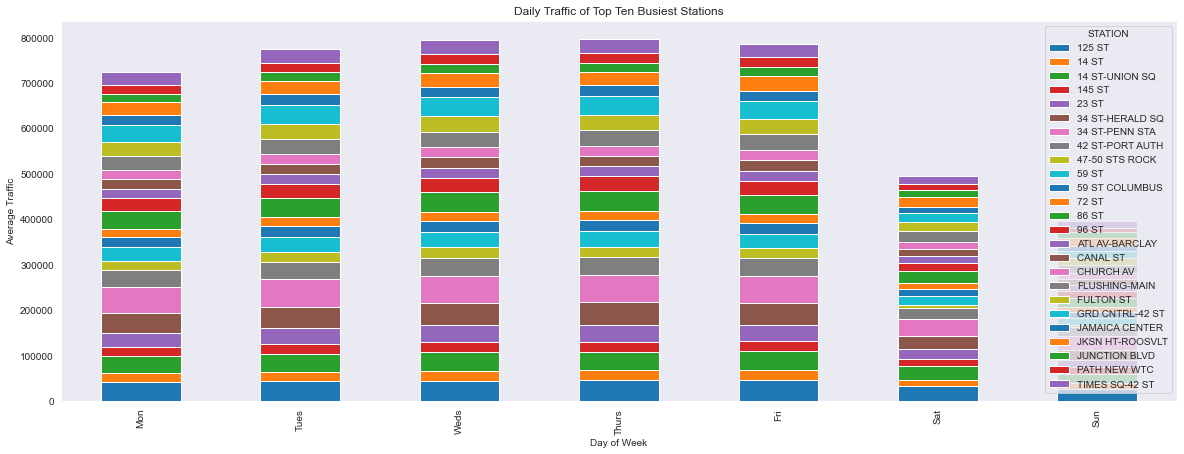

In [81]:
pivot_df.loc[['Mon','Tues','Weds','Thurs','Fri','Sat','Sun'],:].plot.bar(stacked=True, figsize=(20,7))

plt.xlabel('Day of Week')
plt.ylabel('Average Traffic')
plt.title('Daily Traffic of Top Ten Busiest Stations')

In [82]:
col_order=['Mon','Tues','Weds','Thurs','Fri']
pivot_df2 = df[df.STATION.isin(s3)].pivot(index='STATION', columns='day_of_week', values='mean_d_traffic').reindex(col_order, axis=1).reindex(s3, axis=0)

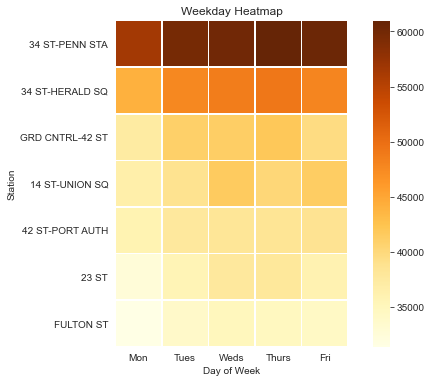

In [83]:
f, ax = plt.subplots(figsize=(9, 6))
sns.heatmap(pivot_df2, annot=False, linewidths=.5, ax=ax, cmap="YlOrBr", square=True)
plt.title('Weekday Heatmap')
plt.xlabel('Day of Week')
plt.ylabel('Station');

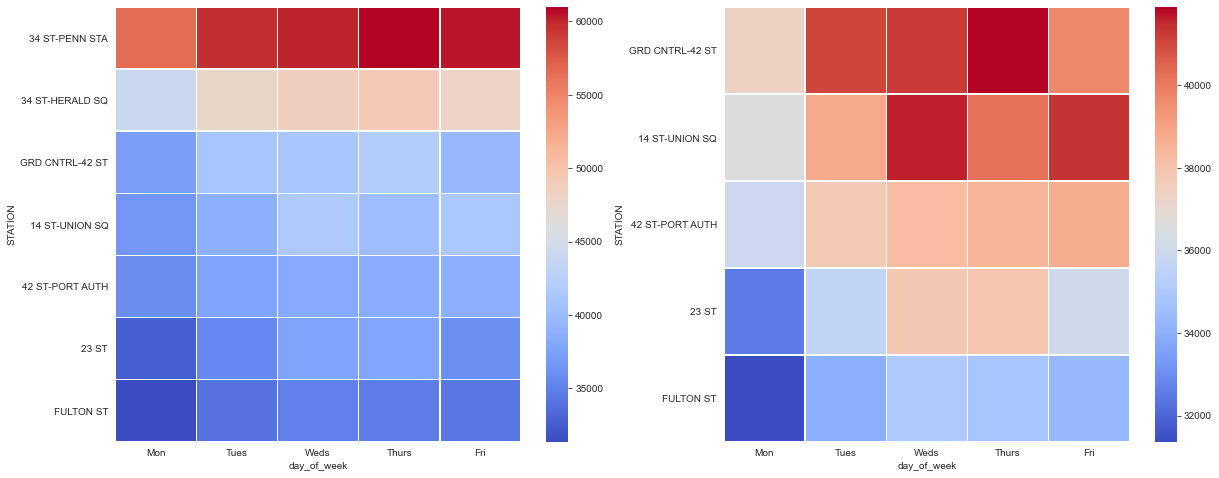

In [84]:
f, ax = plt.subplots(ncols=2, figsize=[20,8])
kwargs = {'square':False, 'linewidths':'0.5', 'annot':False, 'cmap':'coolwarm'}
sns.heatmap(pivot_df2, ax=ax[0], **kwargs)
sns.heatmap(pivot_df2.drop(labels=['34 ST-PENN STA', '34 ST-HERALD SQ']), ax=ax[1], **kwargs);


### Chunking timeslots into windows

break time into categories
00:00:00 < dt.datetime() < 04:00:00 
EX:
* Early Morning  0-5:01
* **Morning Rush Hour 5:02-13:01** <-- 8 hour workdays
* Midafternoon 13:01-17:01
* **Evening Rush Hour 13:02-20:01**
* Late Evening 20:01-24


In [85]:
mta.TIME.value_counts().head(35)

04:00:00    225080
20:00:00    224688
16:00:00    224594
12:00:00    224456
08:00:00    224393
00:00:00    221690
05:00:00    166921
17:00:00    166534
21:00:00    166411
09:00:00    166363
13:00:00    166349
01:00:00    164688
22:00:00     10009
06:00:00      9963
14:00:00      9951
18:00:00      9945
10:00:00      9927
02:00:00      9841
11:00:00      3548
19:00:00      3547
15:00:00      3546
07:00:00      3544
23:00:00      3542
03:00:00      3503
08:22:00      3191
04:22:00      3156
16:22:00      3151
20:22:00      3120
12:22:00      3117
00:22:00      3103
10:30:00      1821
18:30:00      1820
22:30:00      1811
06:30:00      1802
14:30:00      1800
Name: TIME, dtype: int64

In [86]:
import datetime as dt

def time_cat(x):
    curr = x.time()
    
    if dt.time(5,1) < curr < dt.time(13,1):
        return 'Morning'
    elif dt.time(13,1) < curr < dt.time(20,1):
        return 'Evening'
    else:
        return None
    

In [87]:
mta['timeblock'] = mta.datetime.apply(time_cat)

In [88]:
time_df = mta.dropna()[['STATION','DATE','turn_traffic','timeblock','day_of_week']]

In [89]:
time_df['st_daily_traff'] = time_df.groupby(['STATION','DATE','timeblock']).turn_traffic.transform('sum')

In [90]:
time_df['mean_daily_traf'] = time_df.groupby(['STATION','day_of_week','timeblock']).st_daily_traff.transform('mean')

In [91]:
time_df.drop_duplicates(inplace=True)

In [92]:
time_df.sort_values(['timeblock','st_daily_traff'], ascending=False)
time_df.drop(columns=['DATE','st_daily_traff'], inplace=True)
time_df = time_df[time_df.day_of_week<5]

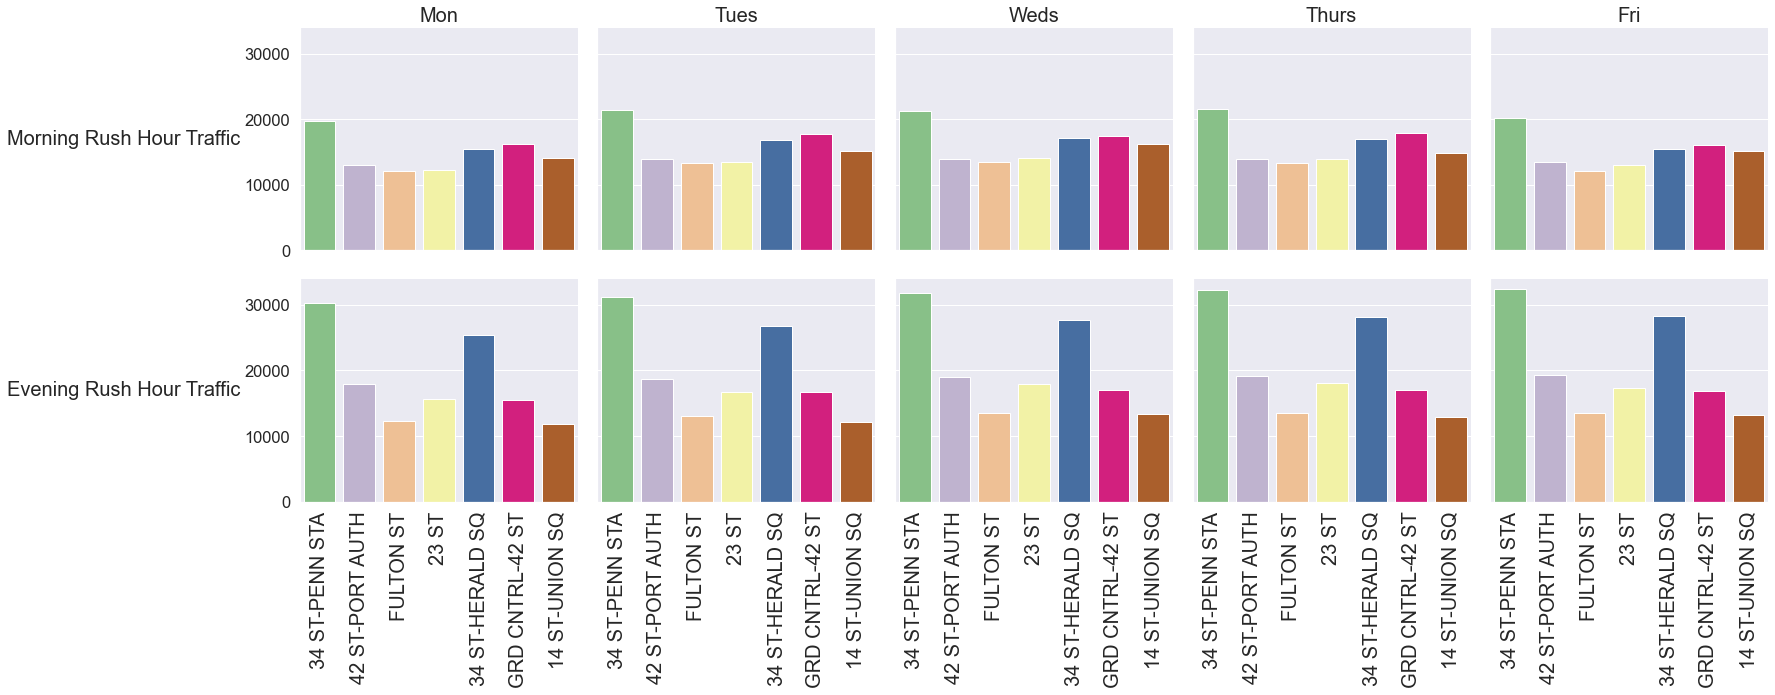

In [93]:
ntime_df = pd.DataFrame(time_df[time_df.STATION.isin(s3)])
ntime_df.drop_duplicates(inplace=True)

sns.set(font_scale=1.5)
d_compare = sns.catplot(
    x='STATION', 
    y='mean_daily_traf', 
    col='day_of_week', 
    row='timeblock', 
    data=ntime_df,
    kind='bar',
    palette='Accent')

d_compare.set_xticklabels(fontsize=20, rotation=90)
d_compare.set_axis_labels("")
d_compare.axes[0,0].set_ylabel('Morning Rush Hour Traffic', fontsize=20, rotation=0, ha='right', va='center')
d_compare.axes[1,0].set_ylabel('Evening Rush Hour Traffic', fontsize=20, rotation=0, ha='right', va='center')

for i, j  in wkday_dict.items():
    try:
        d_compare.axes[0,int(i)].set_title(j, fontsize=20)
        d_compare.axes[1,int(i)].set_title('')
    except:
        pass
plt.tight_layout()

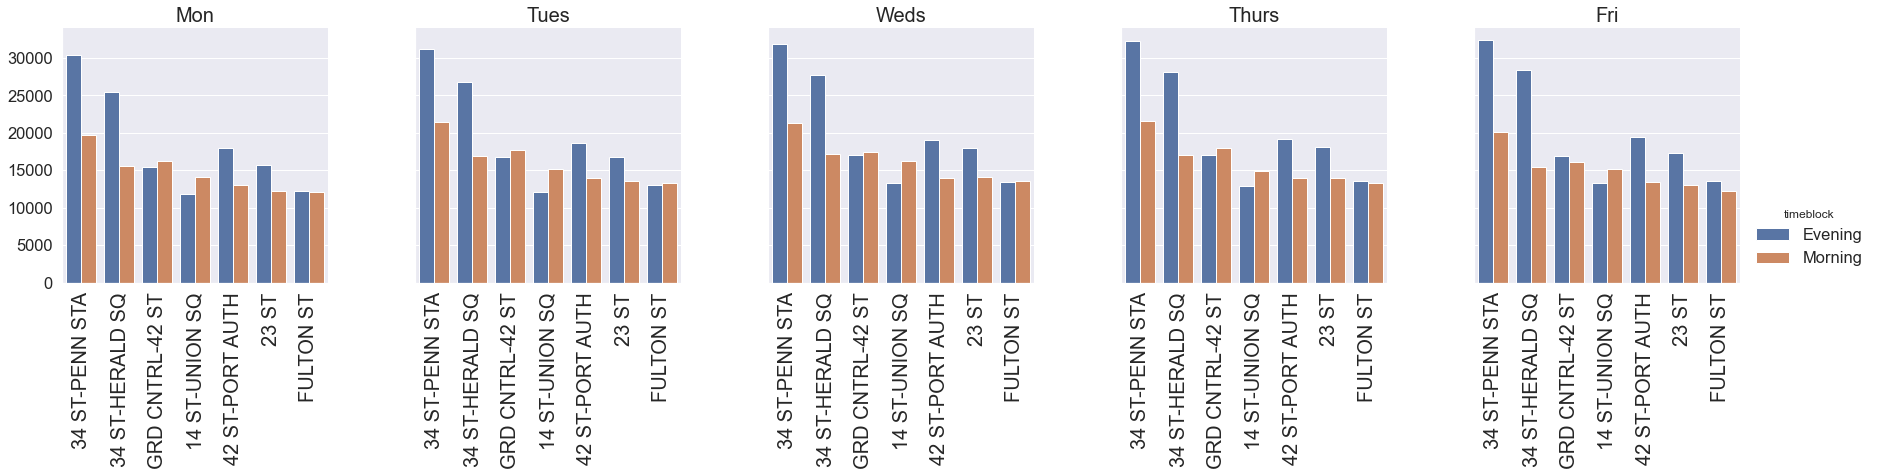

In [94]:
ntime_df = pd.DataFrame(time_df[time_df.STATION.isin(s3)])
ntime_df.drop_duplicates(inplace=True)

sns.set(font_scale=1.5)
d_compare = sns.catplot(
    x='STATION', 
    y='mean_daily_traf', 
    col='day_of_week', 
    hue='timeblock', 
    data=ntime_df,
    kind='bar',
    palette=sns.color_palette(),
    hue_order=['Evening','Morning'],
    order=s3,
    )

d_compare.set_xticklabels(fontsize=20, rotation=90)
d_compare.set_axis_labels("","")
#d_compare.axes[0,0].set_ylabel('Morning Rush Hour Traffic', fontsize=20, rotation=0, ha='right', va='center')
#d_compare.axes[1,0].set_ylabel('Evening Rush Hour Traffic', fontsize=20, rotation=0, ha='right', va='center')
for i, j  in wkday_dict.items():
    try:
        d_compare.axes[0,int(i)].set_title(j, fontsize=20)
        d_compare.axes[1,int(i)].set_title('')
    except:
        pass


In [95]:
wkday_df['timeblock'] = wkday_df.datetime.apply(time_cat)

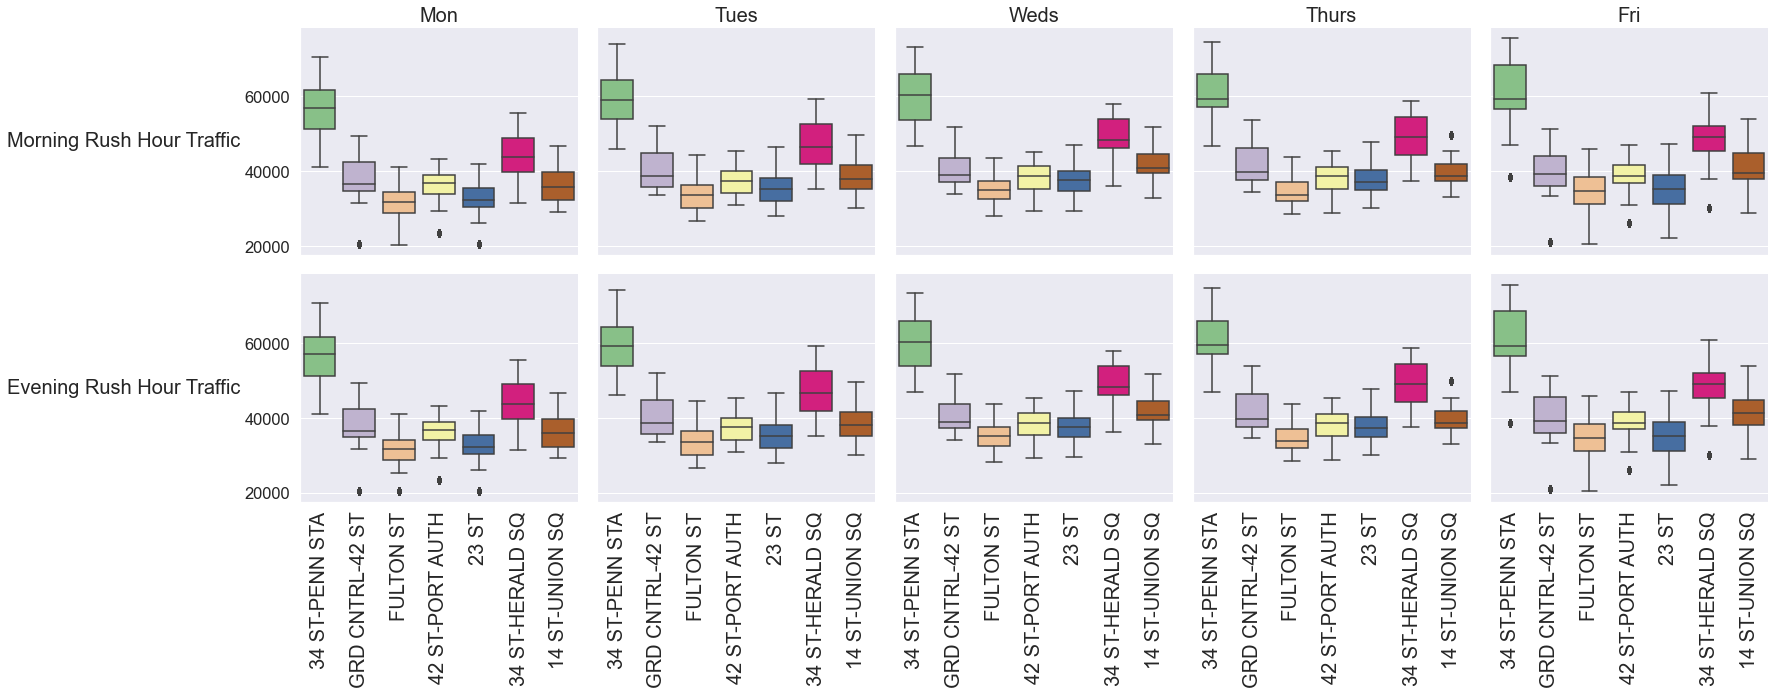

In [96]:
sns.set(font_scale=1.5)
boxy = sns.catplot(data=wkday_df[wkday_df.STATION.isin(s3)], kind='box', x='STATION', y='daily_traffic', col='day_of_week', row='timeblock', palette='Accent')

boxy.set_xticklabels(fontsize=20, rotation=90)
boxy.set_axis_labels("")
boxy.axes[0,0].set_ylabel('Morning Rush Hour Traffic', fontsize=20, rotation=0, ha='right', va='center')
boxy.axes[1,0].set_ylabel('Evening Rush Hour Traffic', fontsize=20, rotation=0, ha='right', va='center')

for i, j  in wkday_dict.items():
    try:
        boxy.axes[0,int(i)].set_title(j, fontsize=20)
        boxy.axes[1,int(i)].set_title('')
    except:
        pass
plt.tight_layout()

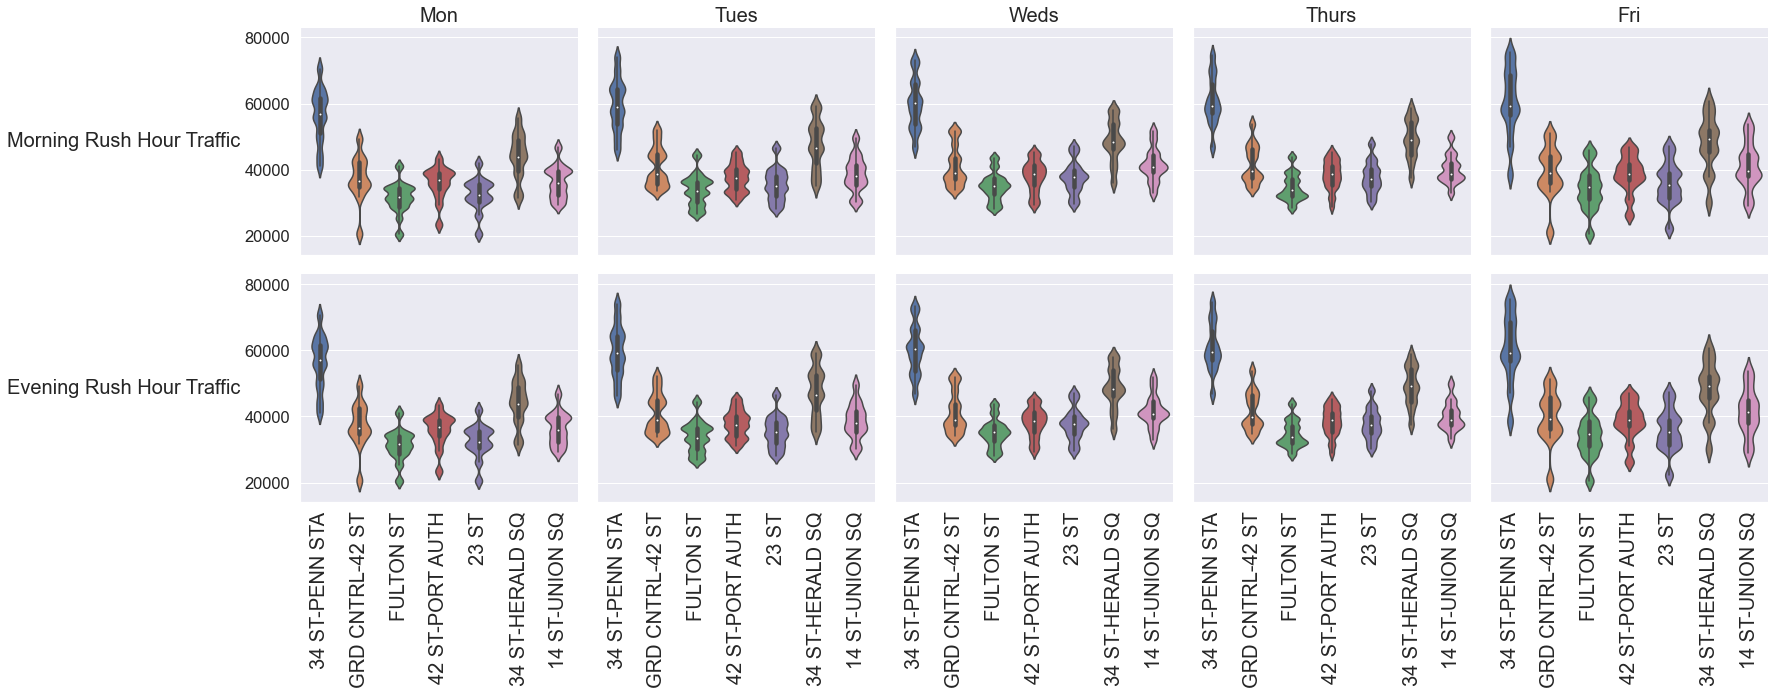

In [97]:
boxy = sns.catplot(data=wkday_df[wkday_df.STATION.isin(s3)], kind='violin', x='STATION', y='daily_traffic', col='day_of_week', row='timeblock')

boxy.set_xticklabels(fontsize=20, rotation=90)
boxy.set_axis_labels("")
boxy.axes[0,0].set_ylabel('Morning Rush Hour Traffic', fontsize=20, rotation=0, ha='right', va='center')
boxy.axes[1,0].set_ylabel('Evening Rush Hour Traffic', fontsize=20, rotation=0, ha='right', va='center')

for i, j  in wkday_dict.items():
    try:
        boxy.axes[0,int(i)].set_title(j, fontsize=20)
        boxy.axes[1,int(i)].set_title('')
    except:
        pass
plt.tight_layout()

* horizontal(pending zach) barplot - total ridership/traffic
* horizontal barplot for top 25
* Stacked Barplot - total traffic 2019vs2020 comparrison top 10
* vertical barplot - Ridership Hotspot by Weekdays
* ~~barplot - Ridership Hotspot Rush-hour by Weekdays 

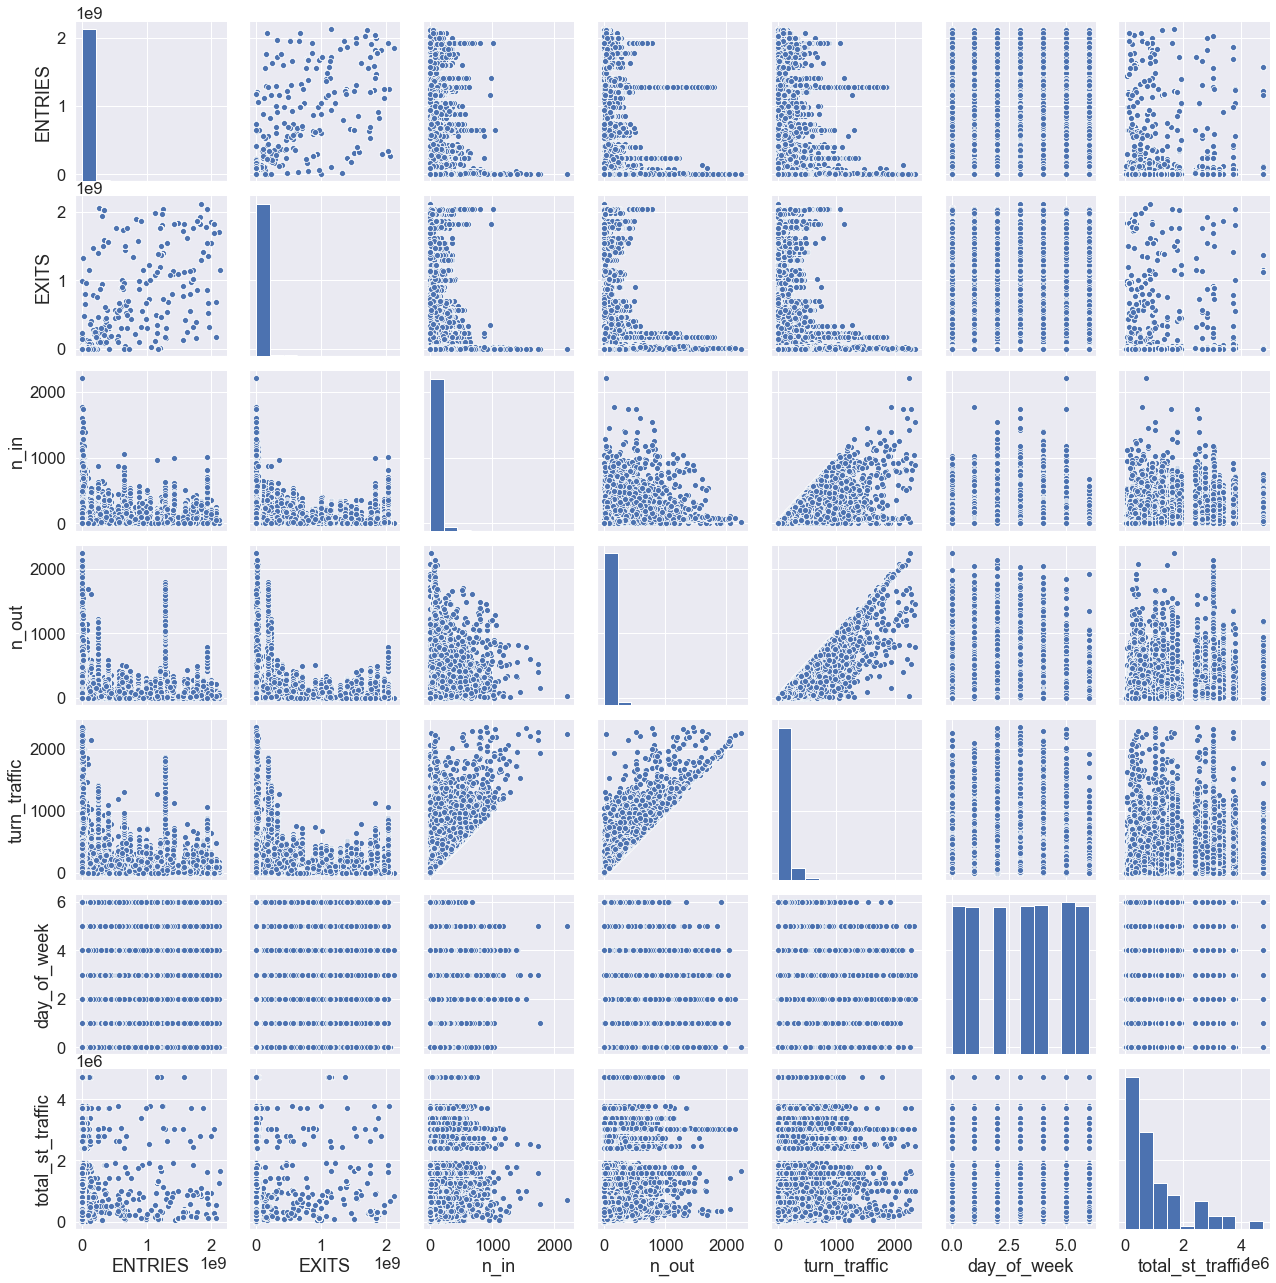

In [98]:
sns.pairplot(mta)

In [99]:
mta.TIME()

TypeError: 'Series' object is not callable

In [ ]:
wkday_df.head()

In [ ]:
wkday_df['hr_traff'] = wkday_df.groupby(['STATION','datetime']).turn_traffic.transform('sum')

In [ ]:
t_comp = pd.DataFrame(wkday_df[['datetime','hr_traff', 'TIME']])
t_comp.drop_duplicates(inplace=True)

In [ ]:
t_comp.drop_duplicates(inplace=True)

In [ ]:
test = wkday_df.groupby(['STATION','datetime'], as_index=False).turn_traffic.sum()

In [ ]:
test.head()

In [ ]:
test[0]

In [ ]:
x = ntime_df[ntime_df.day_of_week==3].drop(columns='turn_traffic')

In [ ]:
plt.figure(figsize=[15,7])

sns.barplot(y='STATION', x='mean_daily_traf', hue='timeblock', data=x, order=s3, hue_order=['Evening', 'Morning'])

plt.xlabel('Traffic')
plt.ylabel('')
plt.title('Thursday Traffic')


In [ ]:
plt.figure(figsize=[15,7])

sns.barplot(x='STATION', y='mean_daily_traf', hue='timeblock', data=x, order=s3, hue_order=['Evening', 'Morning'])

plt.xticks(rotation=45)
plt.xlabel('Traffic')
plt.ylabel('');

In [ ]:
sns.boxplot(x='turn_traffic', y='STATION', hue='timeblock', data=ntime_df[ntime_df.day_of_week==3])

In [ ]:
mta.LINENAME.map(len).value_counts()